In [1]:
import sys
sys.path.append('../../')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

from packages import general, fmm

In [2]:
np.random.seed(0)

num_particles = 1000

terms = 4

particles = [general.Particle() for _ in range(num_particles)]

pair_method = general.Pairwise(particles)
normal_fmm_method = fmm.FMM(particles, terms)
normal_max_level = normal_fmm_method.max_level
max_levels = [normal_max_level - 1, normal_max_level, normal_max_level + 1]
fmm_methods = [
    fmm.FMM(particles, terms, max_levels[0]),
    normal_fmm_method,
    fmm.FMM(particles, terms, max_levels[2])
]

In [3]:
pair_method.do_method()
pair_pot = np.array([p.potential for p in particles])
pair_force = np.array([p.force_per for p in particles])

fmm_pots = []
fmm_forces = []

for f in fmm_methods:
    f.do_method()
    fmm_pots.append(np.array([p.potential for p in particles]))
    fmm_forces.append(np.array([p.force_per for p in particles]))

In [4]:
# fractional errors in potentials
fmm_pots_fracs = [abs((pot - pair_pot) / pair_pot) for pot in fmm_pots]

# magnitudes and angles of forces
pair_force_mag     = np.linalg.norm(pair_force, axis=1)
pair_force_angle   = np.arctan2(pair_force[:,1], pair_force[:,0])
fmm_forces_mag = [np.linalg.norm(force, axis=1) for force in fmm_forces]
fmm_forces_angle = [np.arctan2(force[:,1], force[:,0]) for force in fmm_forces]

# fractional errors in force magnitudes
fmm_forces_mag_frac = [abs((force_mag - pair_force_mag) / pair_force_mag) for force_mag in fmm_forces_mag]

# fractional errors in forces angles
# smallest angluar difference between over 2pi
fmm_forces_angle_frac = []
for force_angle in fmm_forces_angle:
    delta = abs(force_angle - pair_force_angle) % (2*np.pi)
    fmm_forces_angle_frac.append(np.minimum(delta, 2*np.pi - delta) / 2*np.pi)

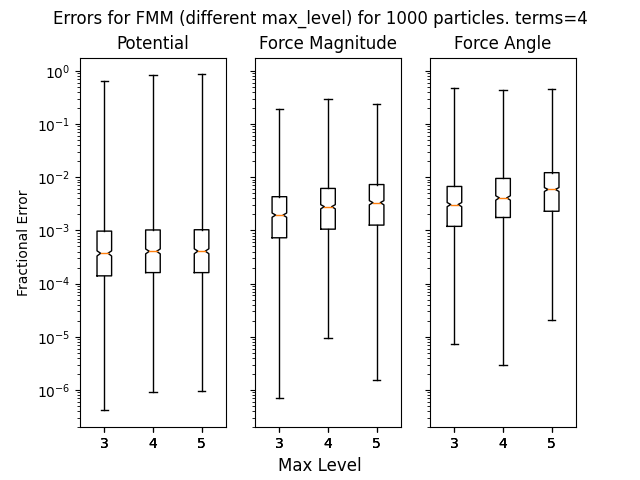

In [6]:
data_pots = fmm_pots_fracs
data_mag = fmm_forces_mag_frac
data_angle = fmm_forces_angle_frac

x_labels = max_levels

FILE_PATH = 'error_data/max_level.npz'
np.savez(FILE_PATH, 
    data_pots=data_pots,
    data_mag=data_mag,
    data_angle=data_angle,
    x_labels=x_labels
)

fig, axs = plt.subplots(1, 3, sharex='all', sharey='all')
ax1, ax2, ax3 = axs

fig.suptitle(f'Errors for FMM (different max_level) for {num_particles} particles. terms={terms}')
fig.supxlabel('Max Level')

ax1.boxplot(data_pots,  notch=True, whis=(0,100))
ax2.boxplot(data_mag,   notch=True, whis=(0,100))
ax3.boxplot(data_angle, notch=True, whis=(0,100))

full_x_labels = list(x_labels)*3

ax1.set_yscale('log')
ax1.set_ylabel('Fractional Error')
ax1.set_xticks(ax1.get_xticks(), full_x_labels)
ax1.set_title('Potential')
ax2.set_title('Force Magnitude')
ax3.set_title('Force Angle');